In [ ]:
# -*- coding: utf-8 -*-
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from joblib import dump, load
# import pickle

# GLM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import family
from statsmodels.stats.multitest import multipletests
 
# Modelling
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, ElasticNet, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, StackingRegressor, StackingClassifier
from xgboost import XGBRegressor, XGBClassifier
import xgboost
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from mlxtend.regressor import StackingCVRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import matplotlib.pyplot as plt

# Mertrics
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error, \
    accuracy_score, confusion_matrix, precision_score, roc_curve, recall_score, \
        precision_recall_curve, precision_recall_fscore_support, roc_auc_score, \
            ConfusionMatrixDisplay, r2_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, cross_validate
from scipy.stats import randint

os.chdir('/Users/jhou2/Documents/GitHub/PertussisVaccine_Prediction/')

In [42]:
# Load data
subject_specimen_df = pd.read_csv('data/output/subject_specimen.csv')
Ab_titer_df = pd.read_csv('data/output/Ab_titer.csv')
RNAseq_df = pd.read_csv('data/output/RNAseq.csv')
Cell_Freq_df = pd.read_csv('data/output/Cell_Freq.csv')

In [48]:
Ab_titer_df[(Ab_titer_df['dataset'] != '2023_dataset') & (Ab_titer_df['timepoint'] == 0)]

,specimen_id,IgG_PT,IgG_PRN,IgG_FHA,IgG1_PT,IgG1_PRN,IgG1_FHA,IgG1_FIM2.3,IgG1_TT,IgG1_DT,...,IgG4_OVA,subject_id,dataset,timepoint,infancy_vac,biological_sex,date_of_boost,race,age,age_at_boost
0,1,2.979295,2.006372,26.636688,10.098853,2.044475,4.616537,0.155137,1.578561,3.176943,...,2.833653,1,2020_dataset,0,wP,Female,2016-09-12,White,30,30
9,102,1.232919,1.096891,1.743372,1.899791,1.328943,1.105913,-1.473059,0.843019,1.287448,...,2.053926,13,2020_dataset,0,aP,Male,2016-07-25,White,19,19
36,109,0.945724,1.977415,1.425324,-1.648747,1.938158,0.308922,1.449089,1.863223,2.381868,...,2.183507,14,2020_dataset,0,wP,Male,2016-08-15,White,23,23
54,114,0.196815,1.005308,1.823017,-5.022841,-0.000014,0.833370,-1.610675,-0.686615,-0.961291,...,1.062777,15,2020_dataset,0,wP,Male,2016-08-15,Asian,27,27
80,121,2.279289,0.602752,2.685105,4.185719,1.361650,3.642262,-1.340657,1.576998,2.816677,...,0.079344,16,2020_dataset,0,wP,Female,2016-07-25,Unknown or Not Reported,29,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,902,6.051650,-1.904160,2.341280,9.861642,3.007505,1.557882,5.908761,2.076000,0.447946,...,3.364642,115,2022_dataset,0,aP,Female,2021-11-01,Asian,19,19
822,912,5.720888,0.785478,0.549210,7.326589,1.489968,1.561535,3.993959,0.652136,1.893976,...,0.253881,116,2022_dataset,0,aP,Male,2021-11-29,White,21,21
831,922,2.029688,4.075797,8.247274,9.366217,2.391124,5.487408,3.325470,1.414389,4.100154,...,0.696527,117,2022_dataset,0,aP,Female,2021-11-29,More Than One Race,27,27
839,932,1.581305,-3.371448,-4.091363,5.761383,-0.321361,-1.453895,-1.736421,0.245841,0.489448,...,1.219559,118,2022_dataset,0,aP,Male,2022-01-24,Asian,24,24


In [3]:
# drop unnecessary columns from each dataframe as sample will be annotated later after merging
excluede_columns = ['subject_id', 'dataset', 'timepoint', 'infancy_vac', 'biological_sex', 'date_of_boost', 'race', 'age', 'age_at_boost']

Ab_titer_df = Ab_titer_df.drop(columns = excluede_columns)
RNAseq_df = RNAseq_df.drop(columns = excluede_columns)
Cell_Freq_df = Cell_Freq_df.drop(columns = excluede_columns)

In [4]:
# Feature engineering: remove non-specific features
remove_features_ab = Ab_titer_df.columns.str.contains('TT|DT|OVA')
Ab_titer_df = Ab_titer_df.loc[:, ~remove_features_ab]

remove_features_cellfreq = Cell_Freq_df.columns.str.contains('CD3CD19neg|CD3.Tcells|B.cells..CD19.CD3.CD14.CD56..|B.cells..CD19.CD20.CD3.CD14.CD56..|CD56.CD3.T.cells|CD4.CD8..T.cells|CD4.CD8..T.cells.1|NK.cells..CD3.CD19.CD56..|CD3.CD19.CD56..cells|non.pDCs|CD3.CD19.CD56.CD14.CD16.CD123.CD11c.HLA.DR.cells|Lineage.negative.cells..CD3.CD19.CD56.HLA.DR.CD123.CD66b..')
Cell_Freq_df = Cell_Freq_df.loc[:, ~remove_features_cellfreq]

# Compute the most variable genes from RNAseq data
gene_matrix = RNAseq_df.drop(columns=['specimen_id'])
gene_variances = gene_matrix.var(axis=0)
top_n = 1000 
top_genes = gene_variances.sort_values(ascending=False).head(top_n).index
filtered_gene_matrix = gene_matrix[top_genes]
filtered_RNAseq_df = pd.concat([RNAseq_df['specimen_id'], filtered_gene_matrix], axis=1)

In [5]:
# Merge all dataframes on 'specimen_id'
all_data_df = pd.merge(Ab_titer_df, 
                       Cell_Freq_df, 
                       on='specimen_id', how='outer')
all_data_df = pd.merge(all_data_df, 
                       filtered_RNAseq_df, 
                       on='specimen_id', how='outer')
print(all_data_df.shape)

# annotate the specimen_id with subject_id and age
all_data_df = pd.merge(all_data_df, 
                       subject_specimen_df, 
                       on='specimen_id', how='inner')
print(all_data_df.shape)

# remove 2023 dataset as it missing target variable
all_data_df = all_data_df[all_data_df['dataset'] != '2023_dataset']
print(all_data_df.shape)

(883, 1047)
(883, 1056)
(721, 1056)


In [6]:
# Extract the feature and target variables from the dataframe
# Feature variables
day0_df = all_data_df[all_data_df['timepoint'] == 0].drop(columns=['specimen_id','timepoint', 'dataset', 'date_of_boost', 'race', 'age_at_boost'])

# Predict target
Ab_titer_day14 = all_data_df[all_data_df['timepoint']== 14][['subject_id', 'IgG_PT']].rename(columns={'IgG_PT': 'IgG_PT_day14'})
Monocytes_day1 = all_data_df[all_data_df['timepoint']== 1][['subject_id', 'Monocytes']].rename(columns={'Monocytes': 'Monocytes_day1'})
CCL3_day3 = all_data_df[all_data_df['timepoint']== 3][['subject_id', 'ENSG00000277632.1']].rename(columns={'ENSG00000277632.1': 'CCL3_day3'})

In [7]:
# Combine Day0 features with target variables
# and compute ratios
final_df = pd.merge(day0_df, Ab_titer_day14, on='subject_id', how='inner')
final_df['IgG_PT_ratio'] = final_df['IgG_PT_day14'] / final_df['IgG_PT']

final_df = pd.merge(final_df, Monocytes_day1, on='subject_id', how='inner')
final_df['Mono_ratio'] = final_df['Monocytes_day1'] / final_df['Monocytes']

final_df = pd.merge(final_df, CCL3_day3, on='subject_id', how='inner')
final_df['CCL3_ratio'] = final_df['CCL3_day3'] / final_df['ENSG00000277632.1']

# clean up final_df.columns
columns_to_exclude = ['subject_id']
final_df = final_df.drop(columns=columns_to_exclude)

In [8]:
# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False)
columns_to_onehot_encode = ['infancy_vac', 'biological_sex']
one_hot_encoded = encoder.fit_transform(final_df[columns_to_onehot_encode])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(columns_to_onehot_encode))

# Concatenate one-hot encoded features with the original DataFrame
final_df_encoded = pd.concat([final_df, one_hot_df], axis=1)
final_df_encoded = final_df_encoded.drop(columns_to_onehot_encode, axis=1)

In [135]:
def data_preprocessing(predictor):
    # Define predictor and drop NaN values in the target variable
    temp = final_df_encoded.dropna(subset=[predictor])

    # Define columns to exclude from features
    no_day0_columns = ['IgG_PT_day14', 'Monocytes_day1', 'CCL3_day3', 'IgG_PT_ratio', 'Mono_ratio', 'CCL3_ratio']

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(temp.drop(columns=no_day0_columns), 
                                                        temp[predictor], 
                                                        test_size=0.3, 
                                                        random_state=42)
    
    # Impute missing values using KNNImputer
    columns_to_exclude = ['age', 'infancy_vac_aP', 'infancy_vac_wP', 'biological_sex_Female', 'biological_sex_Male']
    columns_to_impute = [col for col in X_train.columns if col not in columns_to_exclude]

    # Initialize and fit KNNImputer on training data only
    imputer = KNNImputer(n_neighbors=3)
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[columns_to_impute]), 
                                columns=columns_to_impute, 
                                index=X_train.index)
    X_train_imputed[columns_to_exclude] = X_train[columns_to_exclude]

    # Transform test data using the fitted imputer
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test[columns_to_impute]),
        columns=columns_to_impute, 
        index=X_test.index
    )
    X_test_imputed[columns_to_exclude] = X_test[columns_to_exclude]

    # Standardize the data
    # Fit the standardization scaler onto the training data (only for columns to impute)
    scaler = StandardScaler().fit(X_train_imputed[columns_to_impute])

    # Transform the training data
    X_train_scaled = pd.DataFrame(
        scaler.transform(X_train_imputed[columns_to_impute]),
        columns=columns_to_impute,
        index=X_train_imputed.index
    )
    X_train_scaled[columns_to_exclude] = X_train_imputed[columns_to_exclude]

    # Use the same scaler to transform the testing set
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test_imputed[columns_to_impute]),
        columns=columns_to_impute,
        index=X_test_imputed.index
    )
    X_test_scaled[columns_to_exclude] = X_test_imputed[columns_to_exclude]

    X = pd.concat([X_train_scaled, X_test_scaled], axis=0)
    y = pd.concat([y_train, y_test], axis=0)
    
    return X, y, X_train_scaled, X_test_scaled, y_train, y_test

In [139]:
# Test some basic models, aim to 4 basic models first
def basic_models(X_train, y_train, X_test, y_test):
    # model 1: Lasso Regression
    lasso_basic_model = Lasso(alpha=1, random_state=42)
    lasso_basic_model.fit(X_train, y_train)
    y_pred_lasso = lasso_basic_model.predict(X_test)
    test_score_lasso = lasso_basic_model.score(X_test, y_test)
    rmse_lasso = root_mean_squared_error(y_test, y_pred_lasso)

    # model 2: Ridge Regression
    ridge_basic_model = Ridge(alpha=1, random_state=42)
    ridge_basic_model.fit(X_train, y_train)
    y_pred_ridge = ridge_basic_model.predict(X_test)
    test_score_ridge = ridge_basic_model.score(X_test, y_test)
    rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)

    # model 3: Random Forest
    RF_basic_model = RandomForestRegressor(n_estimators=100, random_state=42)
    RF_basic_model.fit(X_train, y_train)
    y_pred_RF = RF_basic_model.predict(X_test)
    test_score_RF = RF_basic_model.score(X_test, y_test)
    rmse_RF = root_mean_squared_error(y_test, y_pred_RF)

    # model 4: XGBoost
    xgb_basic_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
    xgb_basic_model.fit(X_train, y_train)
    y_pred_xgb = xgb_basic_model.predict(X_test)
    test_score_xgb = xgb_basic_model.score(X_test, y_test)
    rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)

    # model 5: Gradient Boosting
    gb_basic_model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
    gb_basic_model.fit(X_train, y_train)
    y_pred_gb = gb_basic_model.predict(X_test)
    test_score_gb = gb_basic_model.score(X_test, y_test)
    rmse_gb = root_mean_squared_error(y_test, y_pred_gb)

    # model 6: SVM
    svm_basic_model = SVR(kernel='linear')
    svm_basic_model.fit(X_train, y_train)
    y_pred_svm = svm_basic_model.predict(X_test)
    test_score_svm = svm_basic_model.score(X_test, y_test)
    rmse_svm = root_mean_squared_error(y_test, y_pred_svm)

    return pd.DataFrame({
        'Model': ['Lasso', 'Ridge','Random Forest', 'XGBoost', 'Gradient Boosting','SVM'],
        'Test Score': [test_score_lasso, test_score_ridge, test_score_RF, test_score_xgb, test_score_gb, test_score_svm],
        'RMSE': [rmse_lasso, rmse_ridge, rmse_RF, rmse_xgb, rmse_gb, rmse_svm]
    })


In [156]:
def basic_models_cross_val(X, y, cv_folds=5):
    # Define models
    models = {
        'Lasso': Lasso(alpha=1, random_state=42),
        'Ridge': Ridge(alpha=1, random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, random_state=42),
        'SVM': SVR(kernel='linear')
    }
        
    results = []
    scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}
    
    print(f"Sample size: {len(X)}")
    
    for name, model in models.items():
        # Perform k-fold CV
        cv_results = cross_validate(model, X, y, cv=cv_folds, scoring=scoring, n_jobs=-1)
        results.append({
            'Model': name,
            'CV R2 Mean': cv_results['test_r2'].mean(),
            'CV R2 Std': cv_results['test_r2'].std(),
            'CV RMSE Mean': -cv_results['test_rmse'].mean(),
            'CV RMSE Std': -cv_results['test_rmse'].std()
        })
    
    return pd.DataFrame(results)

In [215]:
def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual Values')
    plt.show()

In [187]:
# For CCL3 day3
X, y, X_train_stan, X_test_stan, y_train, y_test = data_preprocessing('CCL3_day3')

In [188]:
# Run basic models for CCL3_day3
basic_models(X_train_stan, y_train, X_test_stan, y_test)

,Model,Test Score,RMSE
0,Lasso,-0.000006,1.647291
1,Ridge,0.243387,1.432868
2,Random Forest,0.313595,1.364769
3,XGBoost,0.186429,1.485822
4,Gradient Boosting,0.270943,1.406533
5,SVM,0.253144,1.423599


In [189]:
# Run basic models for CCL3_day3 with log1p transformation
basic_models(X_train_stan, np.log1p(y_train), X_test_stan, np.log1p(y_test))

,Model,Test Score,RMSE
0,Lasso,-0.001248,0.236674
1,Ridge,0.303638,0.197378
2,Random Forest,0.363082,0.188765
3,XGBoost,0.317816,0.195358
4,Gradient Boosting,0.309384,0.196562
5,SVM,0.307511,0.196828


In [190]:
# Run cross-validation for CCL3_day3
basic_models_cross_val(X, y)

Sample size: 93


,Model,CV R2 Mean,CV R2 Std,CV RMSE Mean,CV RMSE Std
0,Lasso,-0.069198,0.073604,1.482436,-0.155879
1,Ridge,0.052022,0.285885,1.364951,-0.111109
2,Random Forest,0.192524,0.225899,1.258706,-0.046373
3,XGBoost,0.130684,0.152979,1.324309,-0.106439
4,Gradient Boosting,0.174637,0.202583,1.278931,-0.050189
5,SVM,0.062541,0.263517,1.360541,-0.102884


In [191]:
# Run cross-validation for CCL3_day3 with log1p transformation
basic_models_cross_val(X, np.log1p(y))  

Sample size: 93


,Model,CV R2 Mean,CV R2 Std,CV RMSE Mean,CV RMSE Std
0,Lasso,-0.090554,0.109700,0.216258,-0.021805
1,Ridge,0.095904,0.225702,0.194123,-0.017759
2,Random Forest,0.281100,0.148514,0.173328,-0.008867
3,XGBoost,0.077396,0.173491,0.196847,-0.010010
4,Gradient Boosting,0.204829,0.183223,0.182126,-0.011635
5,SVM,0.149176,0.116074,0.190946,-0.022721


In [192]:
# For CCL3_day3 prediction target, Random Forest has the best performance on the basic models. Do hyperparameter tuning with Bayesian optimization
n_iter = 100

search_space_rf = {
    'n_estimators': (50, 500),
    'max_depth': (3, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (2, 20),
    'max_features': ['sqrt', 'log2']
}

# Use negative RMSE as the scoring metric
neg_rmse = make_scorer(root_mean_squared_error, greater_is_better=False)

RF_CCL3_day3_reg_grid = BayesSearchCV(estimator=RandomForestRegressor(random_state=42),
                                      search_spaces=search_space_rf,
                                      n_iter=n_iter,
                                      cv=5,
                                      n_jobs=-1,
                                      scoring=neg_rmse,
                                      random_state=123)

# For CCL3 day3
X, y, X_train_stan, X_test_stan, y_train, y_test = data_preprocessing('CCL3_day3')

RF_CCL3_day3_reg_grid.fit(X_train_stan, np.log1p(y_train))

print("Best Random Forest Classifier Parameters:", RF_CCL3_day3_reg_grid.best_params_)

Best Random Forest Classifier Parameters: OrderedDict([('max_depth', 10), ('max_features', 'sqrt'), ('min_samples_leaf', 8), ('min_samples_split', 2), ('n_estimators', 50)])


In [193]:
RF_CCL3_day3_best = RF_CCL3_day3_reg_grid.best_estimator_
y_pred = RF_CCL3_day3_best.predict(X_test_stan)

r2 = r2_score(np.log1p(y_test), y_pred)
rmse = root_mean_squared_error(np.log1p(y_test), y_pred)
n = X_test_stan.shape[0]
p = X_test_stan.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R-squared: {r2:.4f}")
print(f"Adjusted R-squared: {adjusted_r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R-squared: 0.1652
Adjusted R-squared: 1.0220
RMSE: 0.2161


In [ ]:
plot_predictions(np.log1p(y_test), y_pred)

In [ ]:
cv_scores = cross_val_score(RF_CCL3_day3_best, X_train_stan, np.log1p(y_train), cv=5, scoring='r2')
print(f"Best RF CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

cv_rmse = -cross_val_score(RF_CCL3_day3_best, X_train_stan, np.log1p(y_train), cv=5, scoring='neg_root_mean_squared_error')
print(f"Best RF CV RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

Best RF CV R²: 0.0472 ± 0.0698
Best RF CV RMSE: 0.1901 ± 0.0157


# The test sample size is small, n=28, the test R^2 is not reliable, and small difference in prediction can lead to large difference in R^2. 
# The adjusted R^2 shoulld be < 1, but it is not, due to the number of features (p = 1051) far exceeds the number of samples (n = 28). 
# The small test size lead to overfitting to noise, and the model is not generalizable.

In [195]:
# Using MCIA results as features to preict CCL3_day3
gs_comps10 = pd.read_csv('data/output/gs_comps10.csv')
gs_comps30 = pd.read_csv('data/output/gs_comps30.csv')
gs_comps50 = pd.read_csv('data/output/gs_comps50.csv')

In [224]:
X = gs_comps50.drop(columns=['infancy_vac', 'biological_sex', 'age', 'IgG_PT_day14', 'Monocytes_day1', 'CCL3_day3'])
y = gs_comps50['CCL3_day3']


In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [226]:
n_iter = 100

search_space_rf = {
    'n_estimators': (50, 500),
    'max_depth': (3, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (2, 20),
    'max_features': ['sqrt', 'log2']
}

# Use negative RMSE as the scoring metric
neg_rmse = make_scorer(root_mean_squared_error, greater_is_better=False)

RF_MCIA_CCL3_day3_reg_grid = BayesSearchCV(estimator=RandomForestRegressor(random_state=42),
                                            search_spaces=search_space_rf,
                                            n_iter=n_iter,
                                            cv=5,
                                            n_jobs=-1,
                                            scoring=neg_rmse,
                                            random_state=123)

# For CCL3 day3
RF_MCIA_CCL3_day3_reg_grid.fit(X_train, np.log1p(y_train))

print("Best Random Forest Classifier Parameters:", RF_MCIA_CCL3_day3_reg_grid.best_params_)

Best Random Forest Classifier Parameters: OrderedDict([('max_depth', 20), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 2), ('n_estimators', 379)])


In [227]:
RF_MCIA_CCL3_day3_reg_best = RF_MCIA_CCL3_day3_reg_grid.best_estimator_
y_pred = RF_MCIA_CCL3_day3_reg_best.predict(X_test)

r2 = r2_score(np.log1p(y_test), y_pred)
rmse = root_mean_squared_error(np.log1p(y_test), y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R-squared: {r2:.4f}")
print(f"Adjusted R-squared: {adjusted_r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R-squared: -0.0396
Adjusted R-squared: 2.2204
RMSE: 0.2149


In [228]:
cv_scores = cross_val_score(RF_MCIA_CCL3_day3_reg_best, X, np.log1p(y), cv=5, scoring='r2')
print(f"Best RF CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

cv_rmse = -cross_val_score(RF_MCIA_CCL3_day3_reg_best, X, np.log1p(y), cv=5, scoring='neg_root_mean_squared_error')
print(f"Best RF CV RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

Best RF CV R²: -0.1527 ± 0.0928
Best RF CV RMSE: 0.2110 ± 0.0621


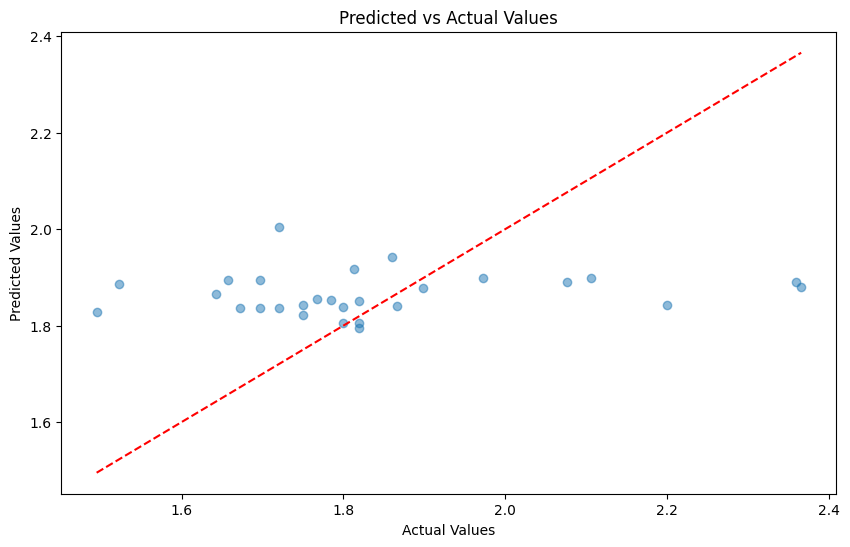

In [223]:
plot_predictions(np.log1p(y_test), y_pred)